# Data Exploratory Analysis (EDA)

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load merged cycles
df = pd.read_csv("../data/processed/hydraulic_cycles.csv")

# define sensor groups and their prefixes
sensor_groups = {
    "PS":   [f"PS{i}" for i in range(1,7)],
    "EPS1": ["EPS1"],
    "FS":   ["FS1","FS2"],
    "LOW":  ["TS1","TS2","TS3","TS4","VS1","CE","CP","SE"]
}

# compute summary stats for each sensor prefix
for group, prefixes in sensor_groups.items():
    for p in prefixes:
        cols = [c for c in df.columns if c.startswith(p + "_")]
        df[f"{p}_mean"] = df[cols].mean(axis=1)
        df[f"{p}_std"]  = df[cols].std(axis=1)
        df[f"{p}_min"]  = df[cols].min(axis=1)
        df[f"{p}_max"]  = df[cols].max(axis=1)

# collect only the newly created summary features
summary_cols = [c for c in df.columns if any(s in c for s in ["_mean","_std","_min","_max"])]



## Univariate Analysis
### 1. Countplots for Each Target

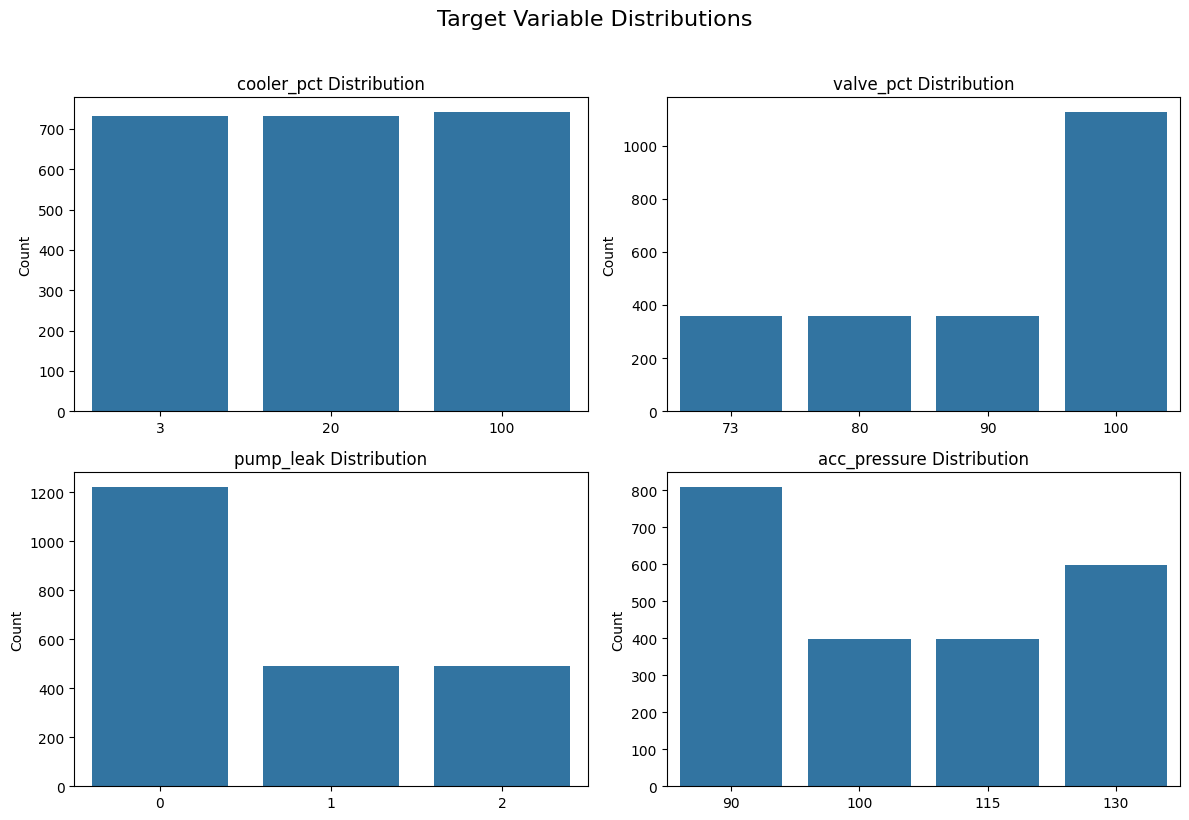

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

targets = ["cooler_pct", "valve_pct", "pump_leak", "acc_pressure"]
for ax, target in zip(axes.flat, targets):
    sns.countplot(x=target, data=df, ax=ax)
    ax.set_title(f"{target} Distribution")
    ax.set_xlabel("")
    ax.set_ylabel("Count")

plt.suptitle("Target Variable Distributions", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


### 2. Summary-Stat Distributions

#### 2.1 Descriptive Statistics Table
A quick `.describe()` on our newly computed features to spot scale differences.


In [20]:
desc = df[summary_cols].describe().T
# display top 8 rows for brevity
desc.head(8)

,count,mean,std,min,25%,50%,75%,max
PS1_mean,2205.0,160.485315,4.699425,155.391547,158.100195,158.960895,161.000735,180.922708
PS1_std,2205.0,15.296219,2.068116,13.927662,14.144613,14.730968,15.050131,22.141793
PS1_min,2205.0,143.472866,2.196514,133.130000,141.230000,143.310000,145.910000,146.690000
PS1_max,2205.0,190.904694,0.602970,189.630000,190.460000,190.960000,191.390000,191.920000
PS2_mean,2205.0,109.379906,4.986585,104.406307,106.962382,107.730169,109.421612,131.589089
PS2_std,2205.0,47.736162,3.271949,45.206954,46.209665,46.805986,47.207567,59.553248
PS2_min,2205.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PS2_max,2205.0,166.520517,0.977997,155.040000,166.180000,166.650000,167.100000,167.770000


#### 2.2 Histograms with KDE
Loop over a few representative features—means and stddevs—to see their shapes.


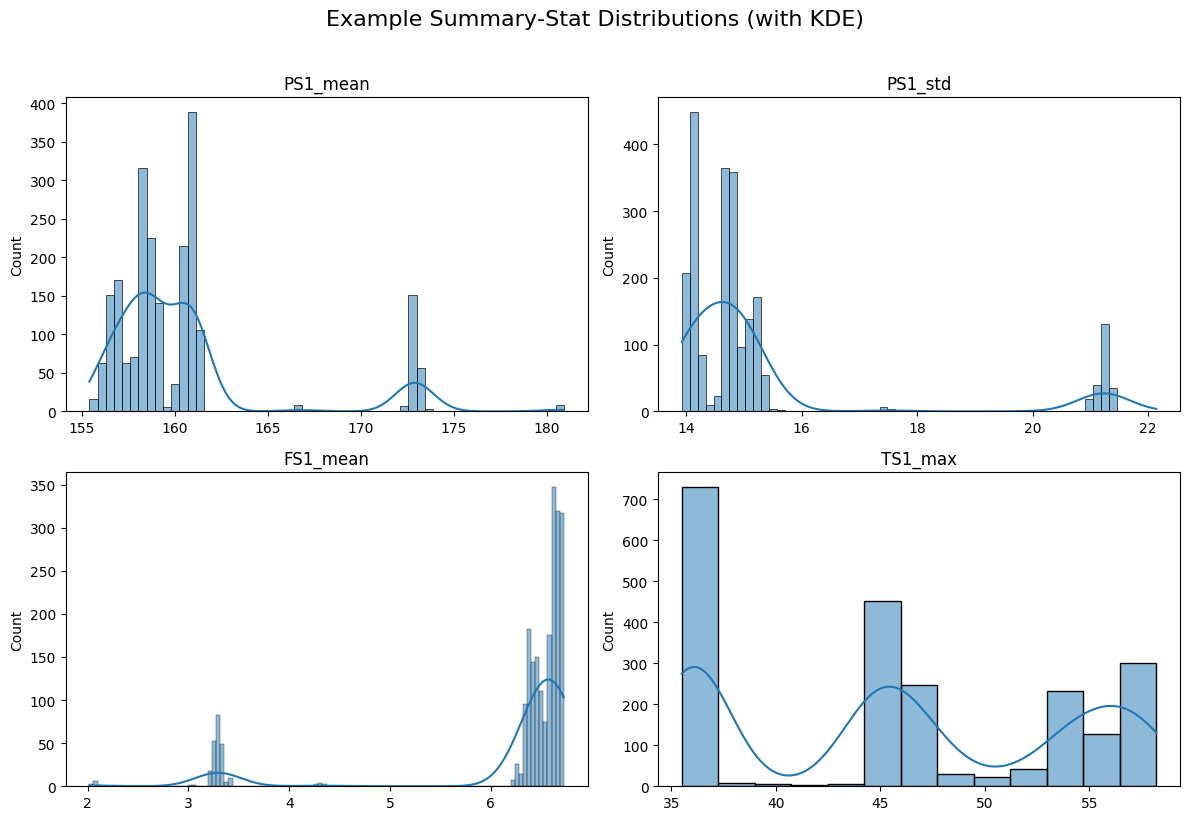

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# pick one representative feature per group (must match actual columns in df)
examples = ["PS1_mean", "PS1_std", "FS1_mean", "TS1_max"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flat, examples):
    sns.histplot(df[feat], ax=ax, kde=True)
    ax.set_title(feat)
    ax.set_xlabel("")
plt.suptitle("Example Summary‑Stat Distributions (with KDE)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


#### 2.3 Boxplots for Outlier Detection
Visualize spread and outliers for the same features.

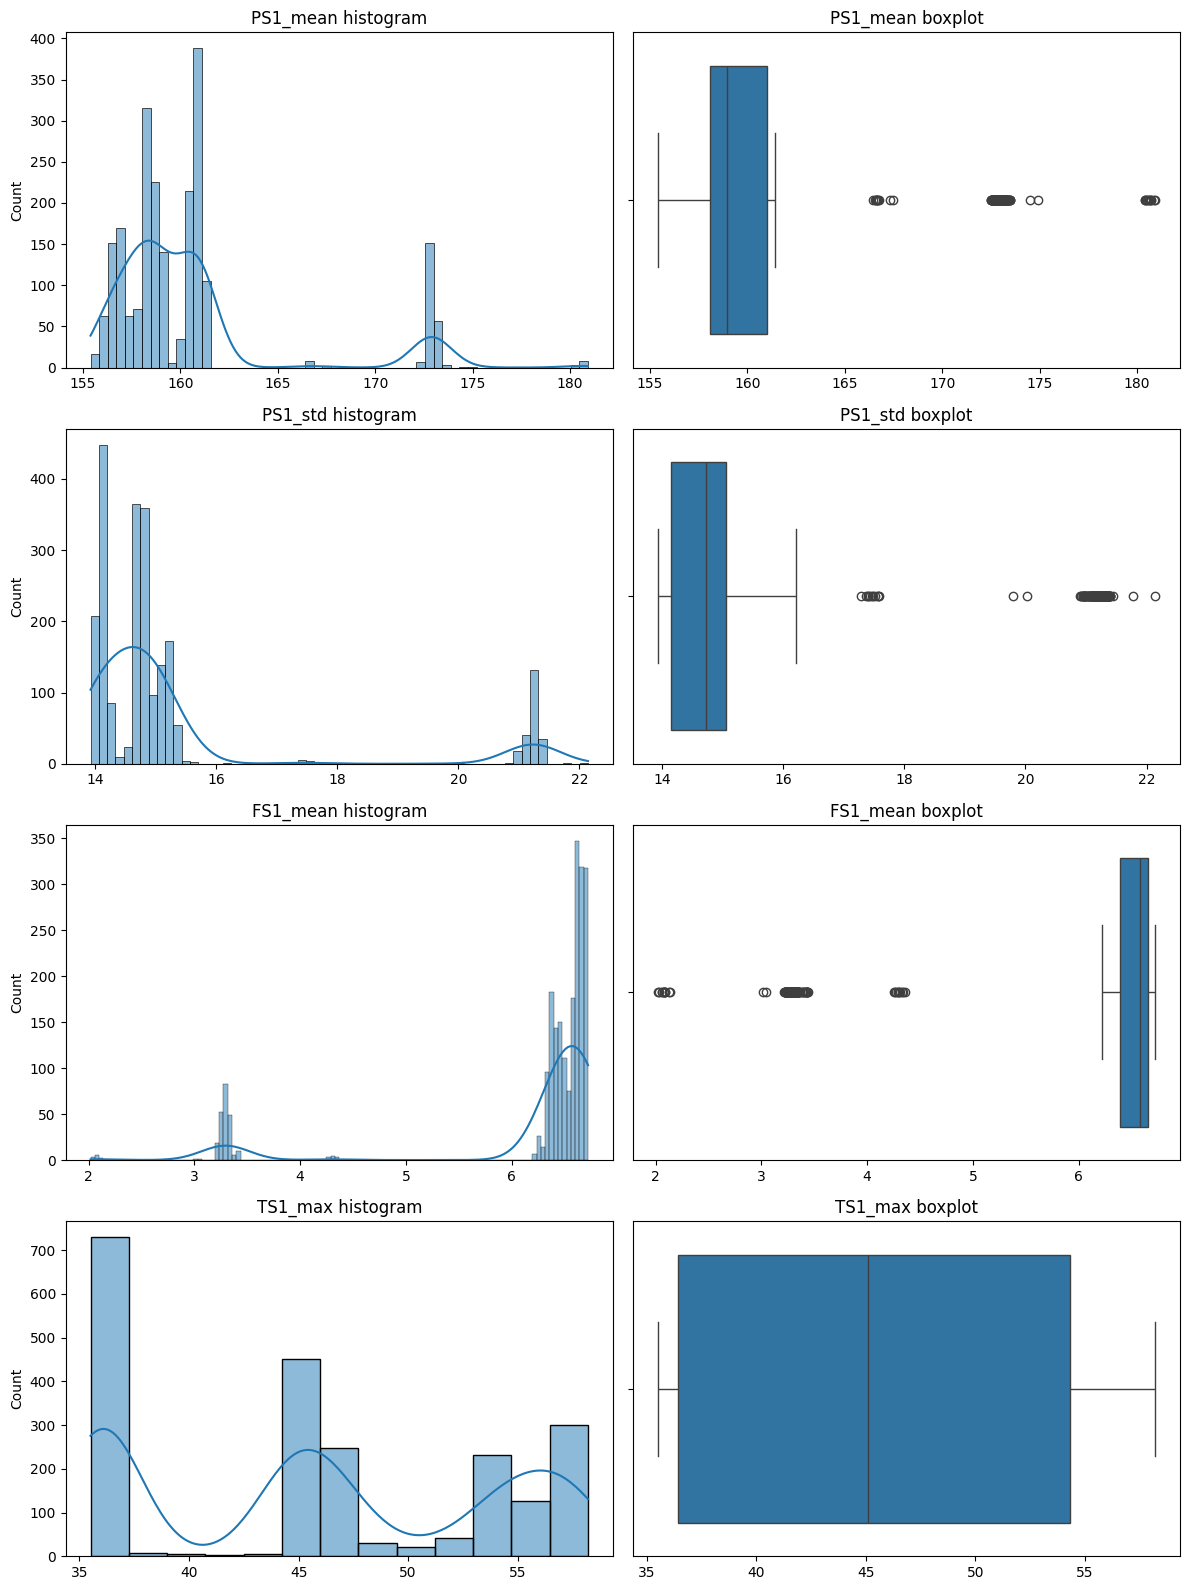

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Verify that our chosen features are present
required = ["PS1_mean", "PS1_std", "FS1_mean", "TS1_max"]
missing  = [f for f in required if f not in df.columns]
if missing:
    raise KeyError(f"Missing required summary‑stat columns: {missing}")

# 2. Re‑plot histograms + KDE and boxplots side by side
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for i, feat in enumerate(required):
    # histogram + KDE
    sns.histplot(df[feat], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f"{feat} histogram")
    axes[i, 0].set_xlabel("")
    
    # boxplot
    sns.boxplot(x=df[feat], ax=axes[i, 1])
    axes[i, 1].set_title(f"{feat} boxplot")
    axes[i, 1].set_xlabel("")

plt.tight_layout()
plt.show()

## Bivariate Analysis

### 1. PS1_mean and PS1_std vs each target

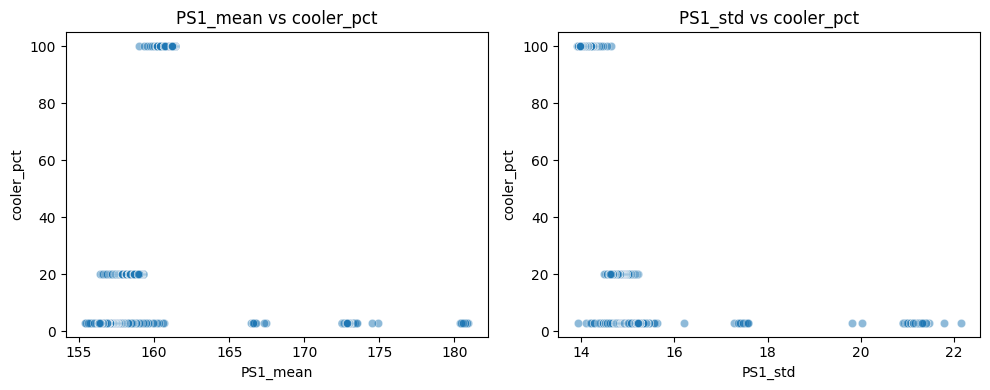

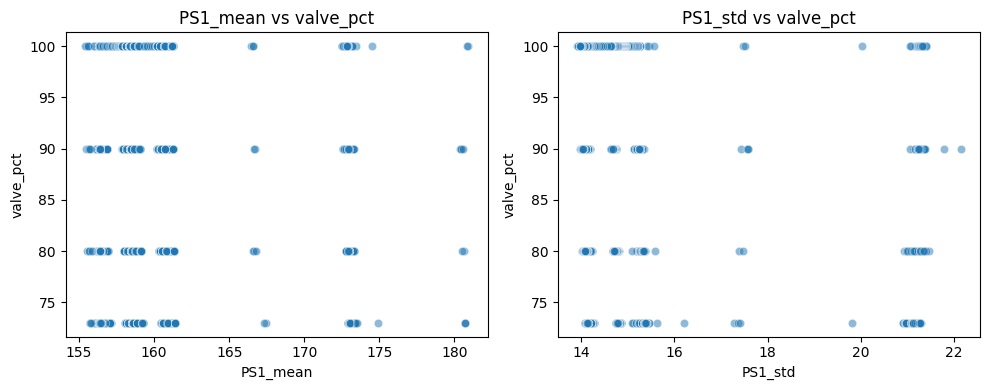

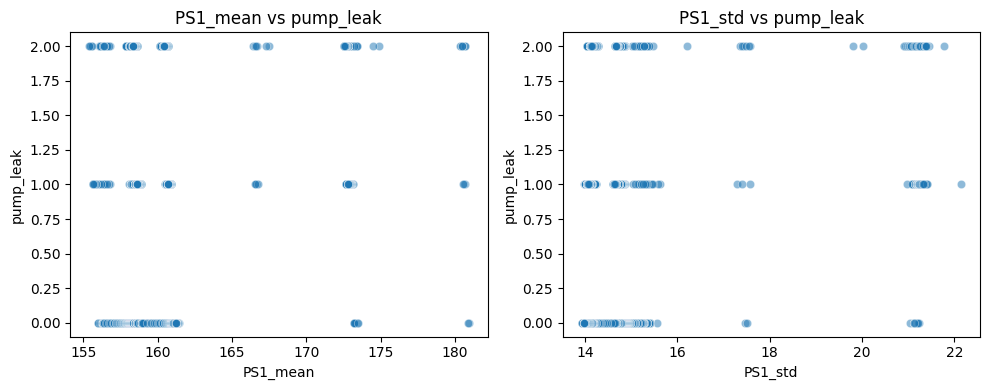

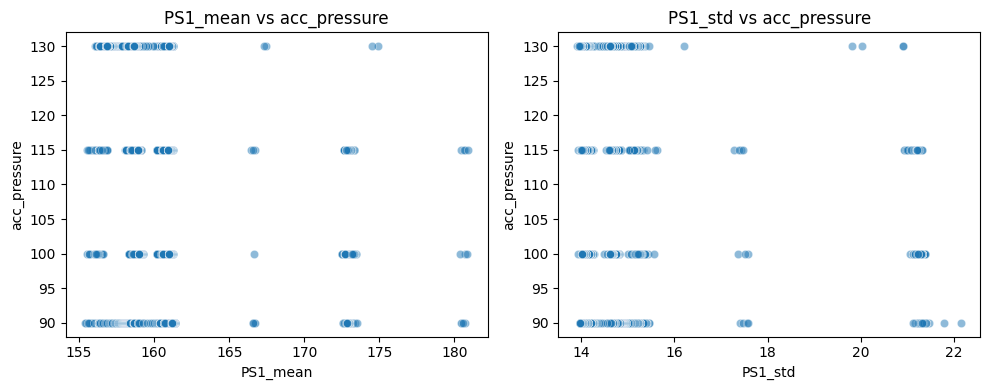

In [23]:
targets  = ["cooler_pct", "valve_pct", "pump_leak", "acc_pressure"]
features = ["PS1_mean", "PS1_std"]

for tgt in targets:
    fig, axes = plt.subplots(1, len(features), figsize=(5 * len(features), 4))
    for ax, feat in zip(axes, features):
        sns.scatterplot(x=feat, y=tgt, data=df, alpha=0.5, ax=ax)
        ax.set_title(f"{feat} vs {tgt}")
        ax.set_xlabel(feat)
        ax.set_ylabel(tgt)
    plt.tight_layout()
    plt.show()

### 2. Correlation Heatmap: All Summary‐Stats vs Targets

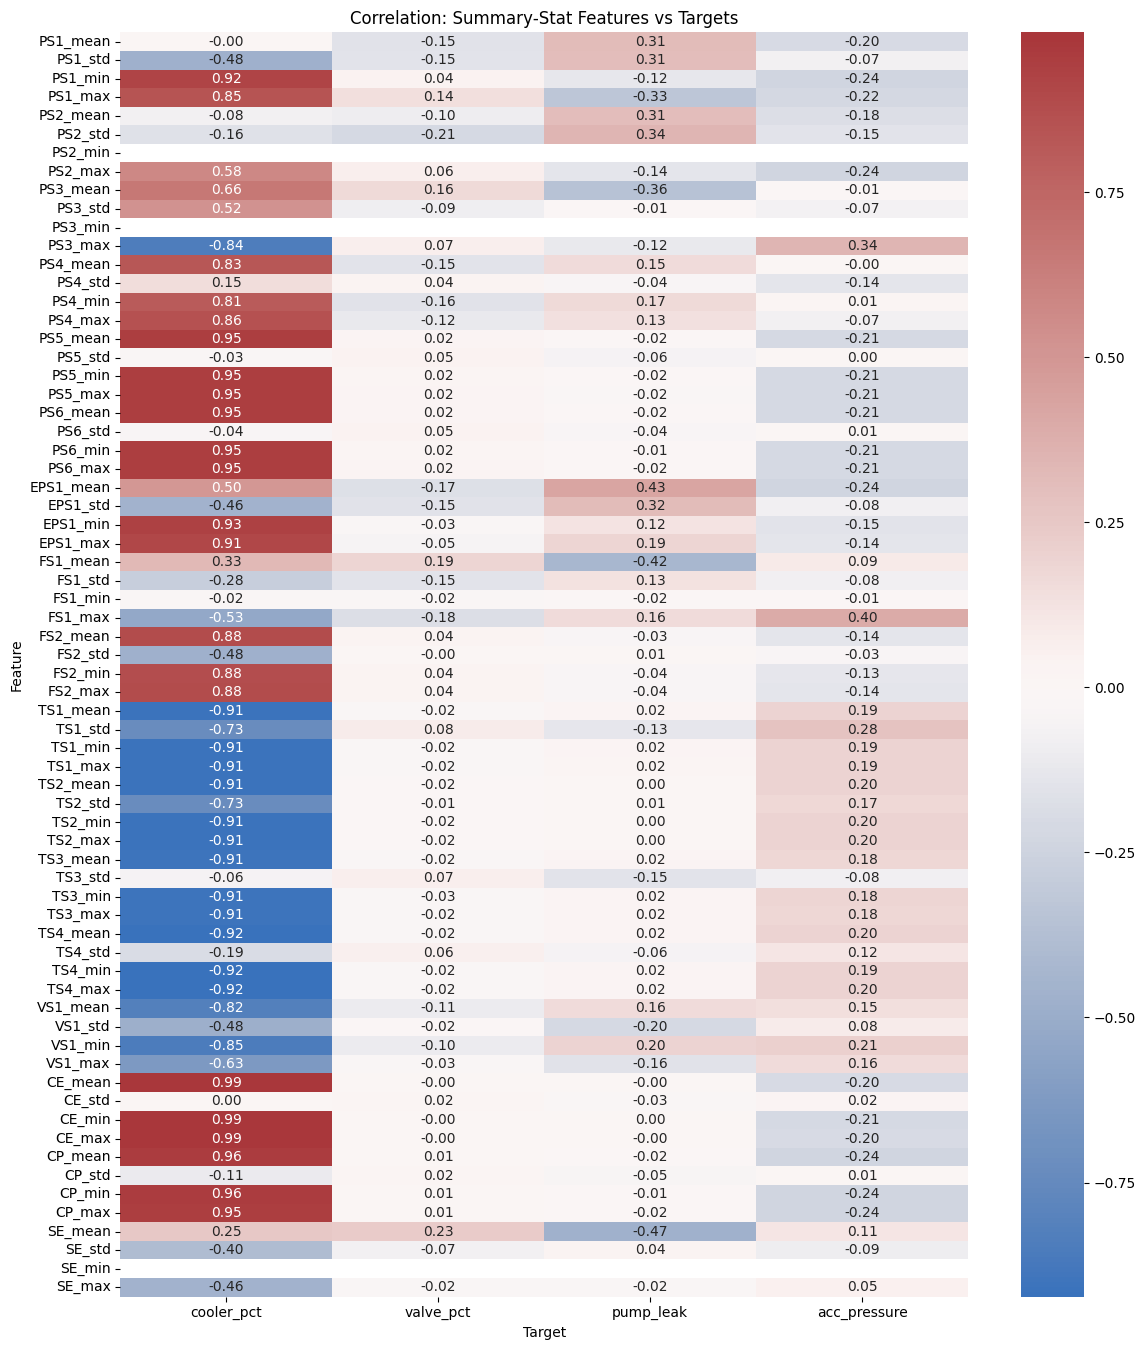

In [24]:
# b) Build list of every summary‐stat feature actually in df
prefixes = [f"PS{i}" for i in range(1,7)] + ["EPS1"] + ["FS1","FS2"] + ["TS1","TS2","TS3","TS4","VS1","CE","CP","SE"]
stat_cols = []
for p in prefixes:
    for suffix in ["mean","std","min","max"]:
        col = f"{p}_{suffix}"
        if col in df.columns:
            stat_cols.append(col)

# assemble df for correlation
corr_df = df[stat_cols + targets]
corr = corr_df.corr()

# show only feature↔target slice
plt.figure(figsize=(12, max(6, len(stat_cols)*0.2)))
sns.heatmap(
    corr.loc[stat_cols, targets],
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0
)
plt.title("Correlation: Summary‐Stat Features vs Targets")
plt.ylabel("Feature")
plt.xlabel("Target")
plt.tight_layout()
plt.show()


### 3. Most-Correlated Features vs Each Target

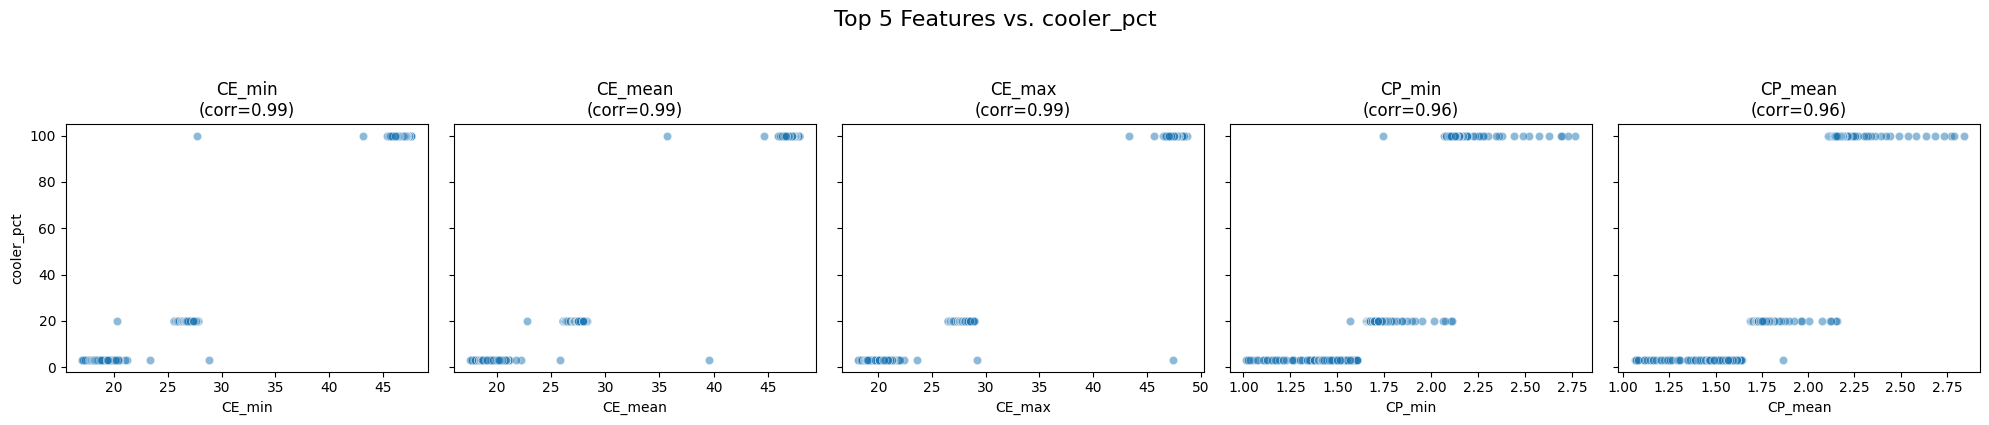

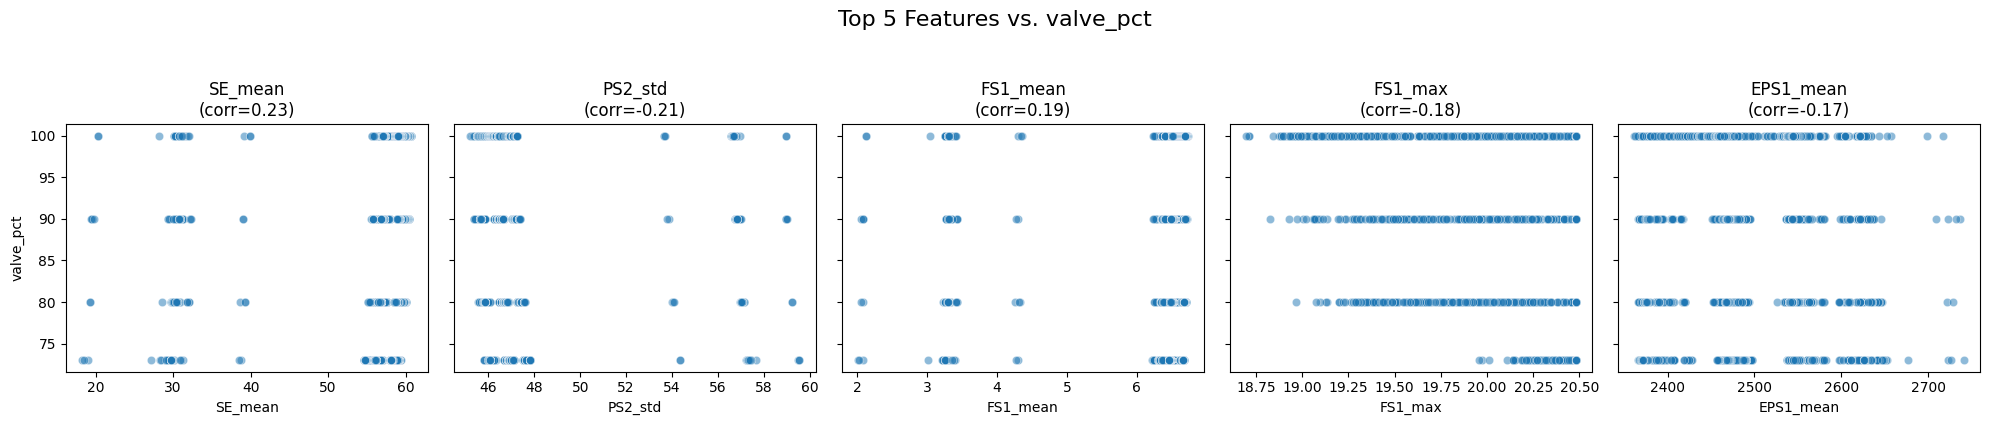

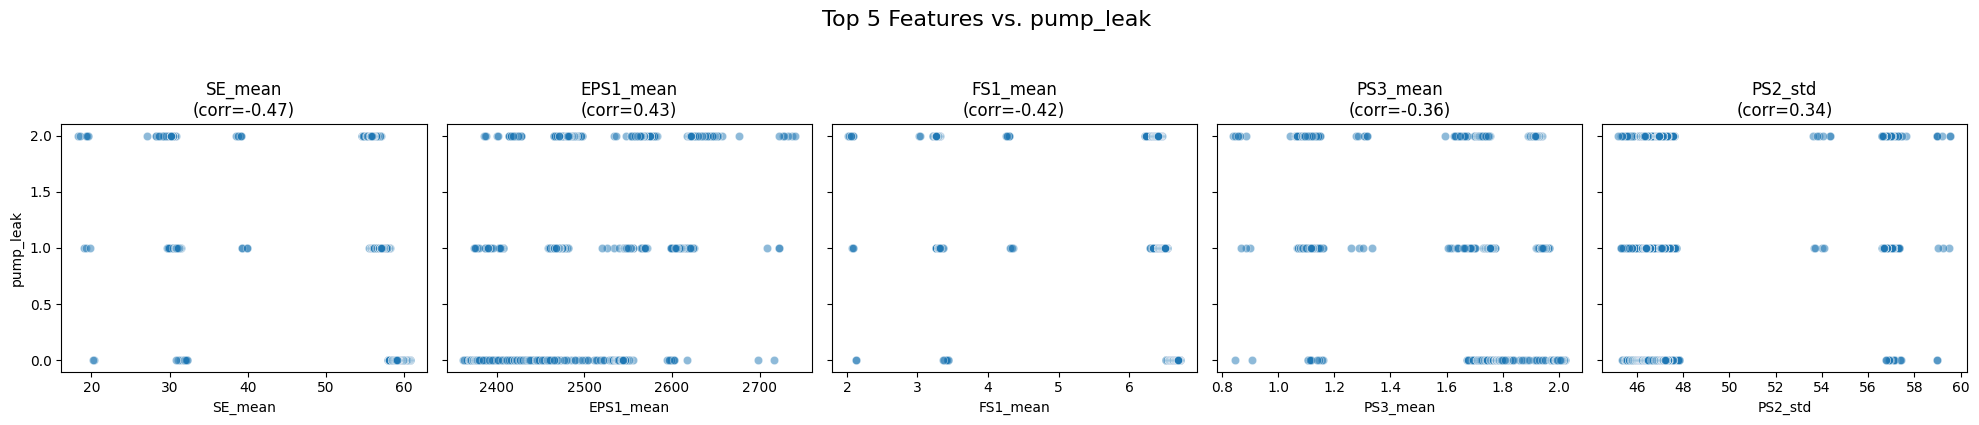

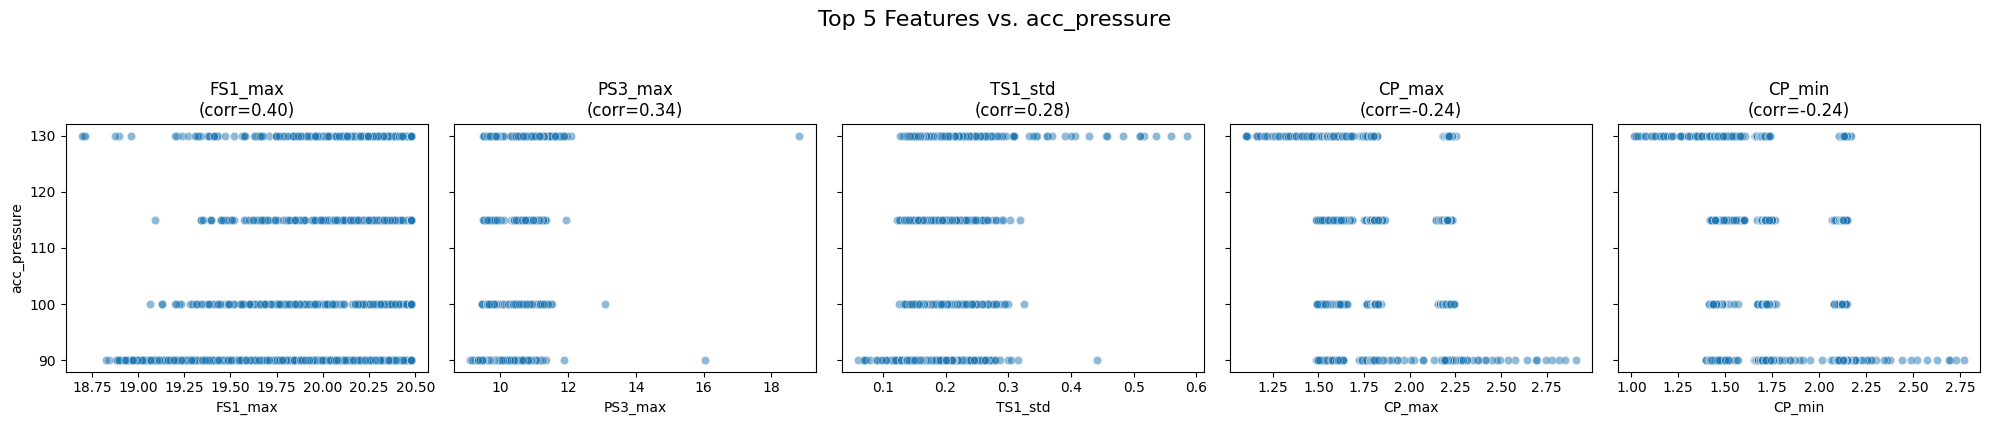

In [25]:
# 1. Gather summary‐stat feature names
stat_cols = [c for c in df.columns if c.endswith(("_mean","_std","_min","_max"))]
targets   = ["cooler_pct", "valve_pct", "pump_leak", "acc_pressure"]

# 2. Compute correlations (feature ↔ target)
corr_df = df[stat_cols + targets].corr().loc[stat_cols, targets]

# 3. For each target, select top‐k features by |corr|
top_k = 5
top_feats = {
    tgt: corr_df[tgt].abs().sort_values(ascending=False).head(top_k).index.tolist()
    for tgt in targets
}

# 4. Plot those best correlates
for tgt, feats in top_feats.items():
    n = len(feats)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)
    fig.suptitle(f"Top {n} Features vs. {tgt}", y=1.05, fontsize=16)
    
    for ax, feat in zip(axes, feats):
        sns.scatterplot(x=df[feat], y=df[tgt], alpha=0.5, ax=ax)
        ax.set_title(f"{feat}\n(corr={corr_df.at[feat,tgt]:.2f})")
        ax.set_xlabel(feat)
        ax.set_ylabel(tgt)
    
    plt.tight_layout()
    plt.show()
